In [9]:
# Import libraries yang dibutuhkan

import pandas as pd
import numpy as np
import re
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from scipy.stats import uniform, randint
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

In [10]:
data_train = pd.read_csv("application_train.csv")
data_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


--- Jumlah Absolut TARGET (0 dan 1) ---
TARGET
0    282686
1     24825
Name: count, dtype: int64

--- Proporsi/Persentase TARGET ---
TARGET
0    91.93
1     8.07
Name: proportion, dtype: float64


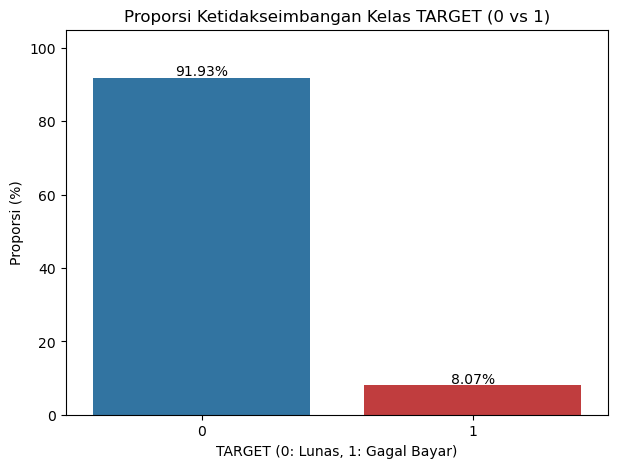

In [11]:
# Membuat grafik untuk melihat proporsi ketidakseimbangan kelas TARGET (0 vs 1)
target_counts = data_train['TARGET'].value_counts()
target_proportions = data_train['TARGET'].value_counts(normalize=True) * 100

print("--- Jumlah Absolut TARGET (0 dan 1) ---")
print(target_counts)

print("\n--- Proporsi/Persentase TARGET ---")
print(target_proportions.round(2))

# Simpan hasil proporsi ke DataFrame untuk visualisasi
df_proportions = target_proportions.reset_index()
df_proportions.columns = ['TARGET', 'Proporsi (%)']

plt.figure(figsize=(7, 5))
sns.barplot(
    x='TARGET',
    y='Proporsi (%)',
    data=df_proportions,
    palette=['#1f77b4', '#d62728'] # Biru untuk 0 (Lunas), Merah untuk 1 (Gagal Bayar)
)

# Menambahkan label nilai di atas setiap bar
for index, row in df_proportions.iterrows():
    plt.text(
        row.name,
        row['Proporsi (%)'] + 0.5,
        f"{row['Proporsi (%)']:.2f}%",
        color='black',
        ha="center"
    )

plt.title('Proporsi Ketidakseimbangan Kelas TARGET (0 vs 1)')
plt.xlabel('TARGET (0: Lunas, 1: Gagal Bayar)')
plt.ylabel('Proporsi (%)')
plt.ylim(0, 105)
plt.show()

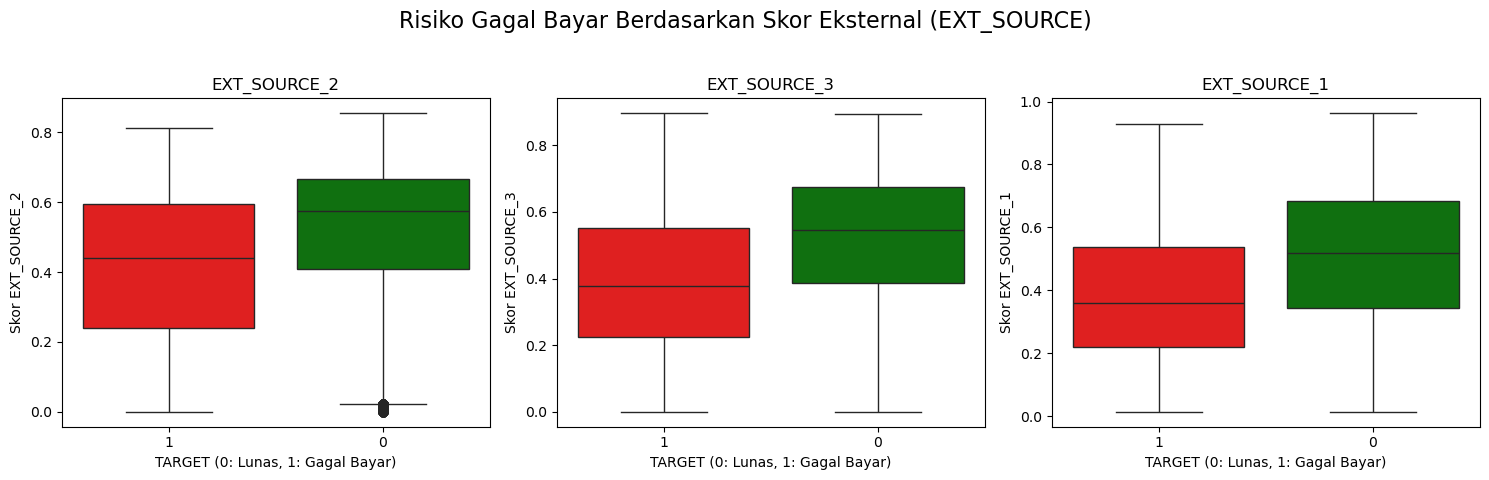

In [12]:
# Membuat boxplot untuk melihat persebaran data masing-masing EXT_SOURCE terhadap TARGET

data_train['TARGET'] = data_train['TARGET'].astype(str)

palette_dict = {'0': 'green', '1': 'red'}
EXT_SOURCE_COLS = ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'EXT_SOURCE_1']

plt.figure(figsize=(15, 5))
plt.suptitle('Risiko Gagal Bayar Berdasarkan Skor Eksternal (EXT_SOURCE)', fontsize=16)

for i, col in enumerate(EXT_SOURCE_COLS):
    plt.subplot(1, 3, i + 1)

    sns.boxplot(
        x='TARGET',
        y=col,
        data=data_train,
        palette=palette_dict  # <--- Menggunakan dictionary yang sudah didefinisikan dengan kunci STRING
    )

    plt.title(f'{col}')
    plt.xlabel('TARGET (0: Lunas, 1: Gagal Bayar)')
    plt.ylabel(f'Skor {col}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [13]:
data_test = pd.read_csv("application_test.csv")
data_test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


Analisis dilakukan dengan membersihkan sekaligus melakukan Feature Engineering pada masing-masing file csv yang kemudian nantinya fitur hasil Feature Engineering digabungkan dengan file train.csv menggunakan key SK_ID_CURR. Setelah itu dilakukan proses Feature Selection menggunakan model LightGBM dan dilanjutkan dengan pembuatan model Logistic Regression, XGBoost, Random Forest, dan LightGBM. Di bagian akhir, feature importances pada model terbaik akan dihitung untuk selanjutnya digunakan sebagai dasar rekomendasi bisnis.